In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('houseprice.csv')

In [14]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [16]:
isnull_series = df.isnull().sum()

In [17]:
isnull_series[isnull_series>0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

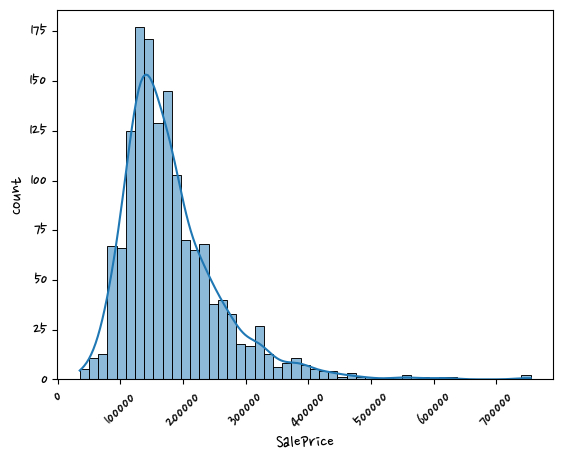

In [18]:
plt.xticks(rotation=45)
sns.histplot(df['SalePrice'],kde=True)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

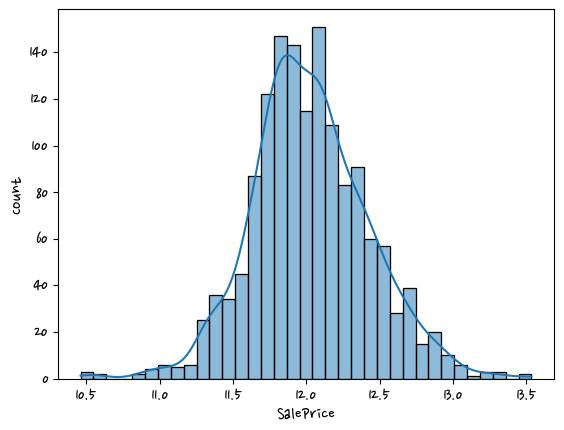

In [19]:
log_saleprice = np.log1p(df['SalePrice'])
sns.histplot(log_saleprice,kde=True)

In [20]:
original_saleprice = df['SalePrice']
df['SalePrice'] =  np.log1p(df['SalePrice'])
df.drop(columns=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Id'],inplace=True)
df.fillna(df.mean(),inplace=True)

In [24]:
null_column_count = df.isnull().sum()[df.isnull().sum()>0]

In [26]:
df.dtypes[null_column_count.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [27]:
df.shape

(1460, 75)

In [28]:
df_ohe = pd.get_dummies(df)

In [29]:
df_ohe.shape

(1460, 271)

In [30]:
def get_rmse(model):
    from sklearn.metrics import mean_squared_error
    import numpy as np
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test,pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,' 로그 변환된 RMSE:',np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [31]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split

In [35]:
y = df_ohe['SalePrice']
X = df_ohe.drop(columns=['SalePrice'])

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=156)

In [37]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

In [43]:
np.expm1(0.13189576579154494)

0.14098938294353924

In [46]:
def get_top_botton_coef(model,n=10):
    coef = pd.Series(model.coef_,index=X.columns)
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high,coef_low

In [49]:
 get_top_botton_coef(lr_reg,3)

(RoofMatl_Membran    0.528057
 RoofMatl_Metal      0.414453
 RoofMatl_WdShngl    0.345254
 dtype: float64,
 Functional_Maj2    -0.426389
 Condition2_PosN    -0.663744
 RoofMatl_ClyTile   -2.372268
 dtype: float64)

In [58]:
def visualize_coefficient(models):
    fig,axs = plt.subplots(figsize=(24,10),nrows=1,ncols=3)
    fig.tight_layout()
    for i_num,model in enumerate(models):
        coef_high,coef_low =  get_top_botton_coef(model)
        coef_concat = pd.concat([coef_high,coef_low])
        axs[i_num].set_title(model.__class__.__name__+ ' Coefficient',size=25)
        axs[i_num].tick_params(axis='y', direction='in',pad=-120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values,y=coef_concat.index, ax=axs[i_num])

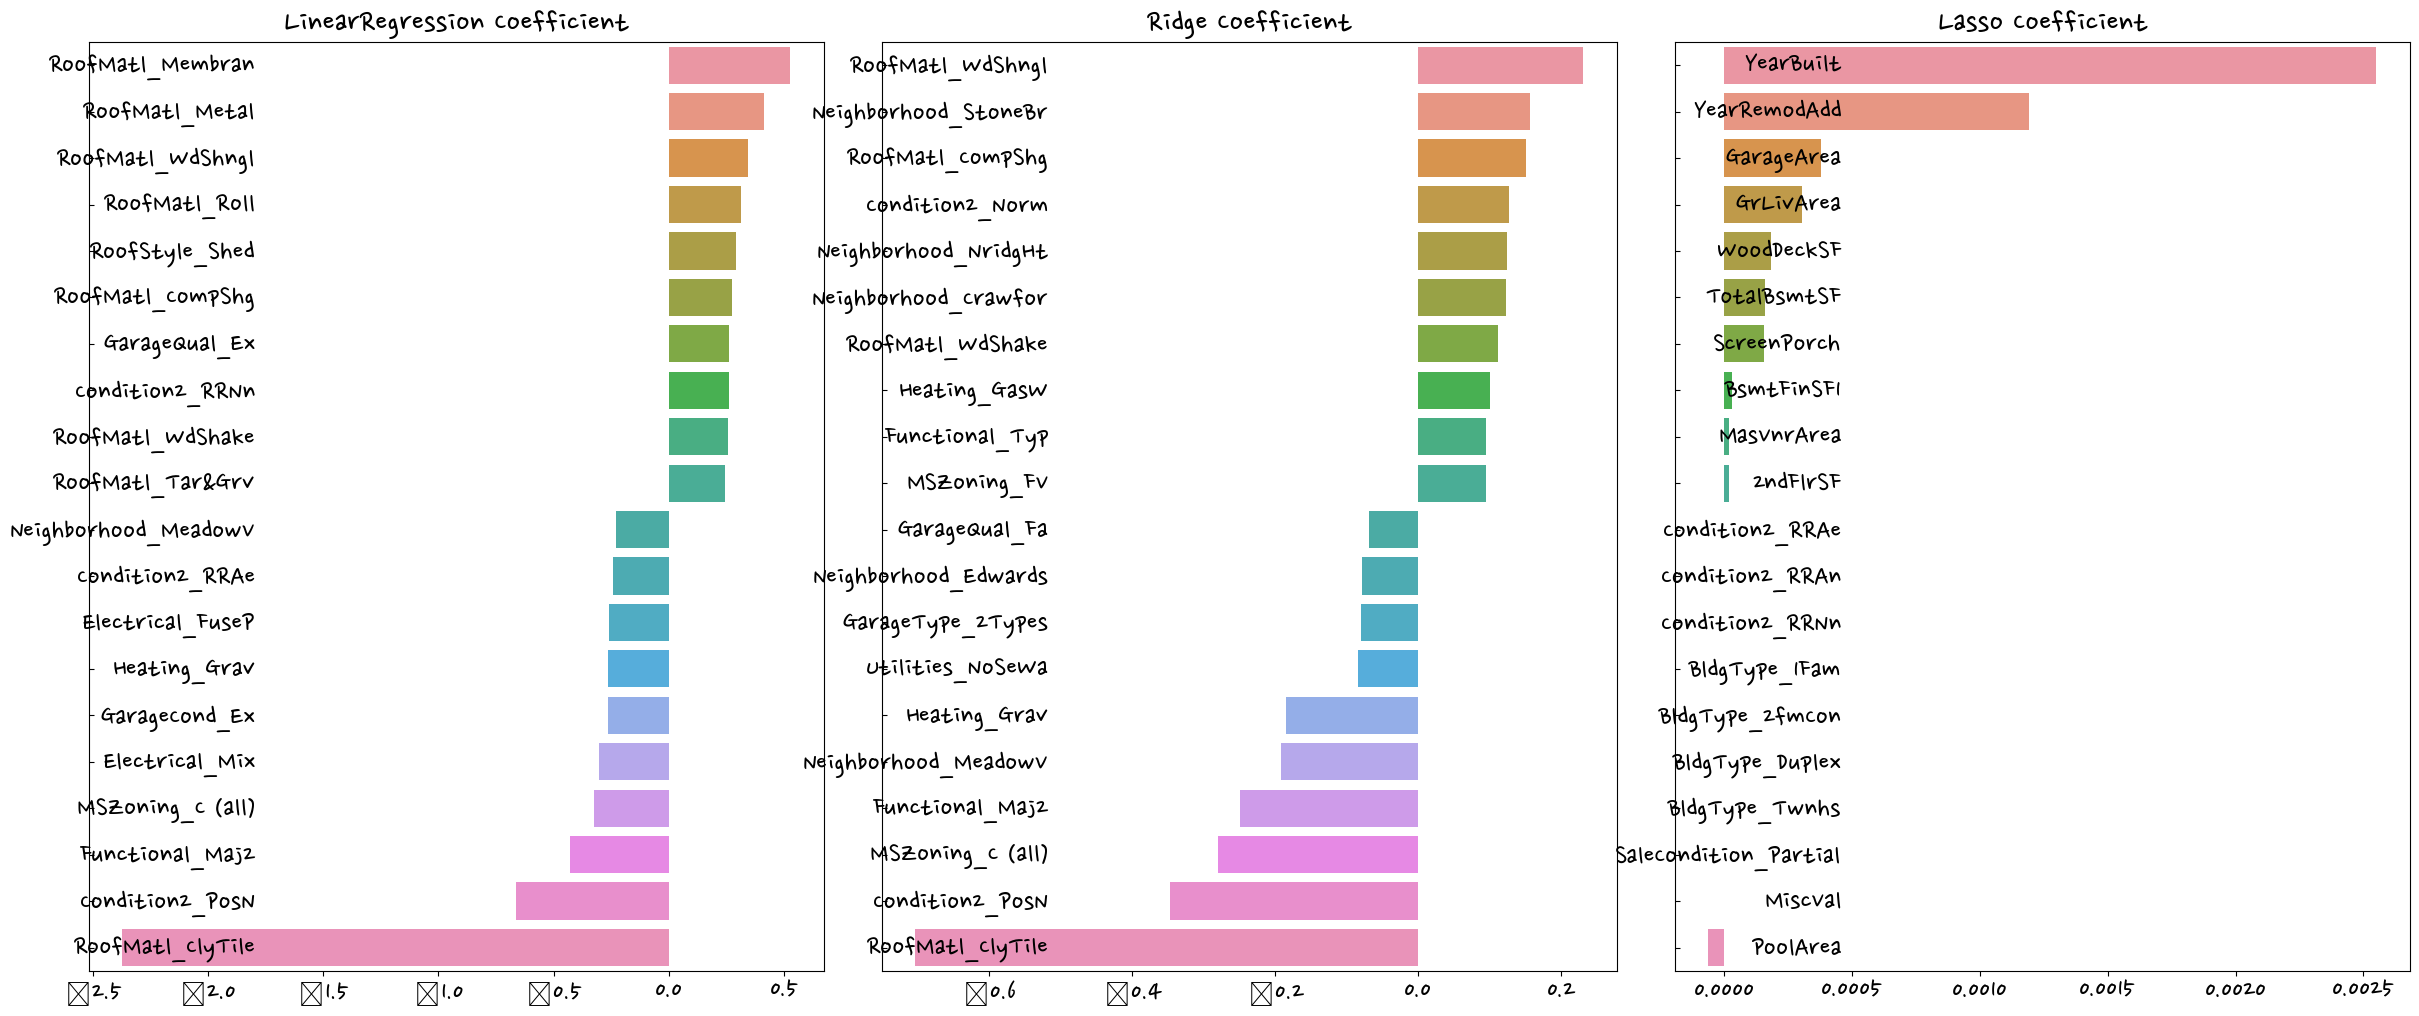

In [59]:
visualize_coefficient(models)

In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'{model.__class__.__name__} cv rmse 값 리스트 : {np.round(rmse_list,3)}')
        print(f'{model.__class__.__name__} cv 평균 rmse 값 : {np.round(rmse_avg,3)}')

In [62]:
get_avg_rmse_cv(models)

LinearRegression cv rmse 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression cv 평균 rmse 값 : 0.155
Ridge cv rmse 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge cv 평균 rmse 값 : 0.144
Lasso cv rmse 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso cv 평균 rmse 값 : 0.198


In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
def print_best_params(model,params):
    grid_model = GridSearchCV(model,params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X,y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print(f'{model.__class__.__name__} 5 cv시 최적 평균 rmse 값:{np.round(rmse,4)}, 최적 alpha값:{grid_model.best_params_}')

In [65]:
ridge_param = {
    'alpha':[0.05,0.1,1,5,8,10,12,15,20]
}
print_best_params(ridge_reg,ridge_param)

Ridge 5 cv시 최적 평균 rmse 값:0.1418, 최적 alpha값:{'alpha': 12}


In [66]:
lasso_param = {
    'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]
}
print_best_params(lasso_reg,lasso_param)

Lasso 5 cv시 최적 평균 rmse 값:0.142, 최적 alpha값:{'alpha': 0.001}


LinearRegression  로그 변환된 RMSE: 0.132
Ridge  로그 변환된 RMSE: 0.124
Lasso  로그 변환된 RMSE: 0.12


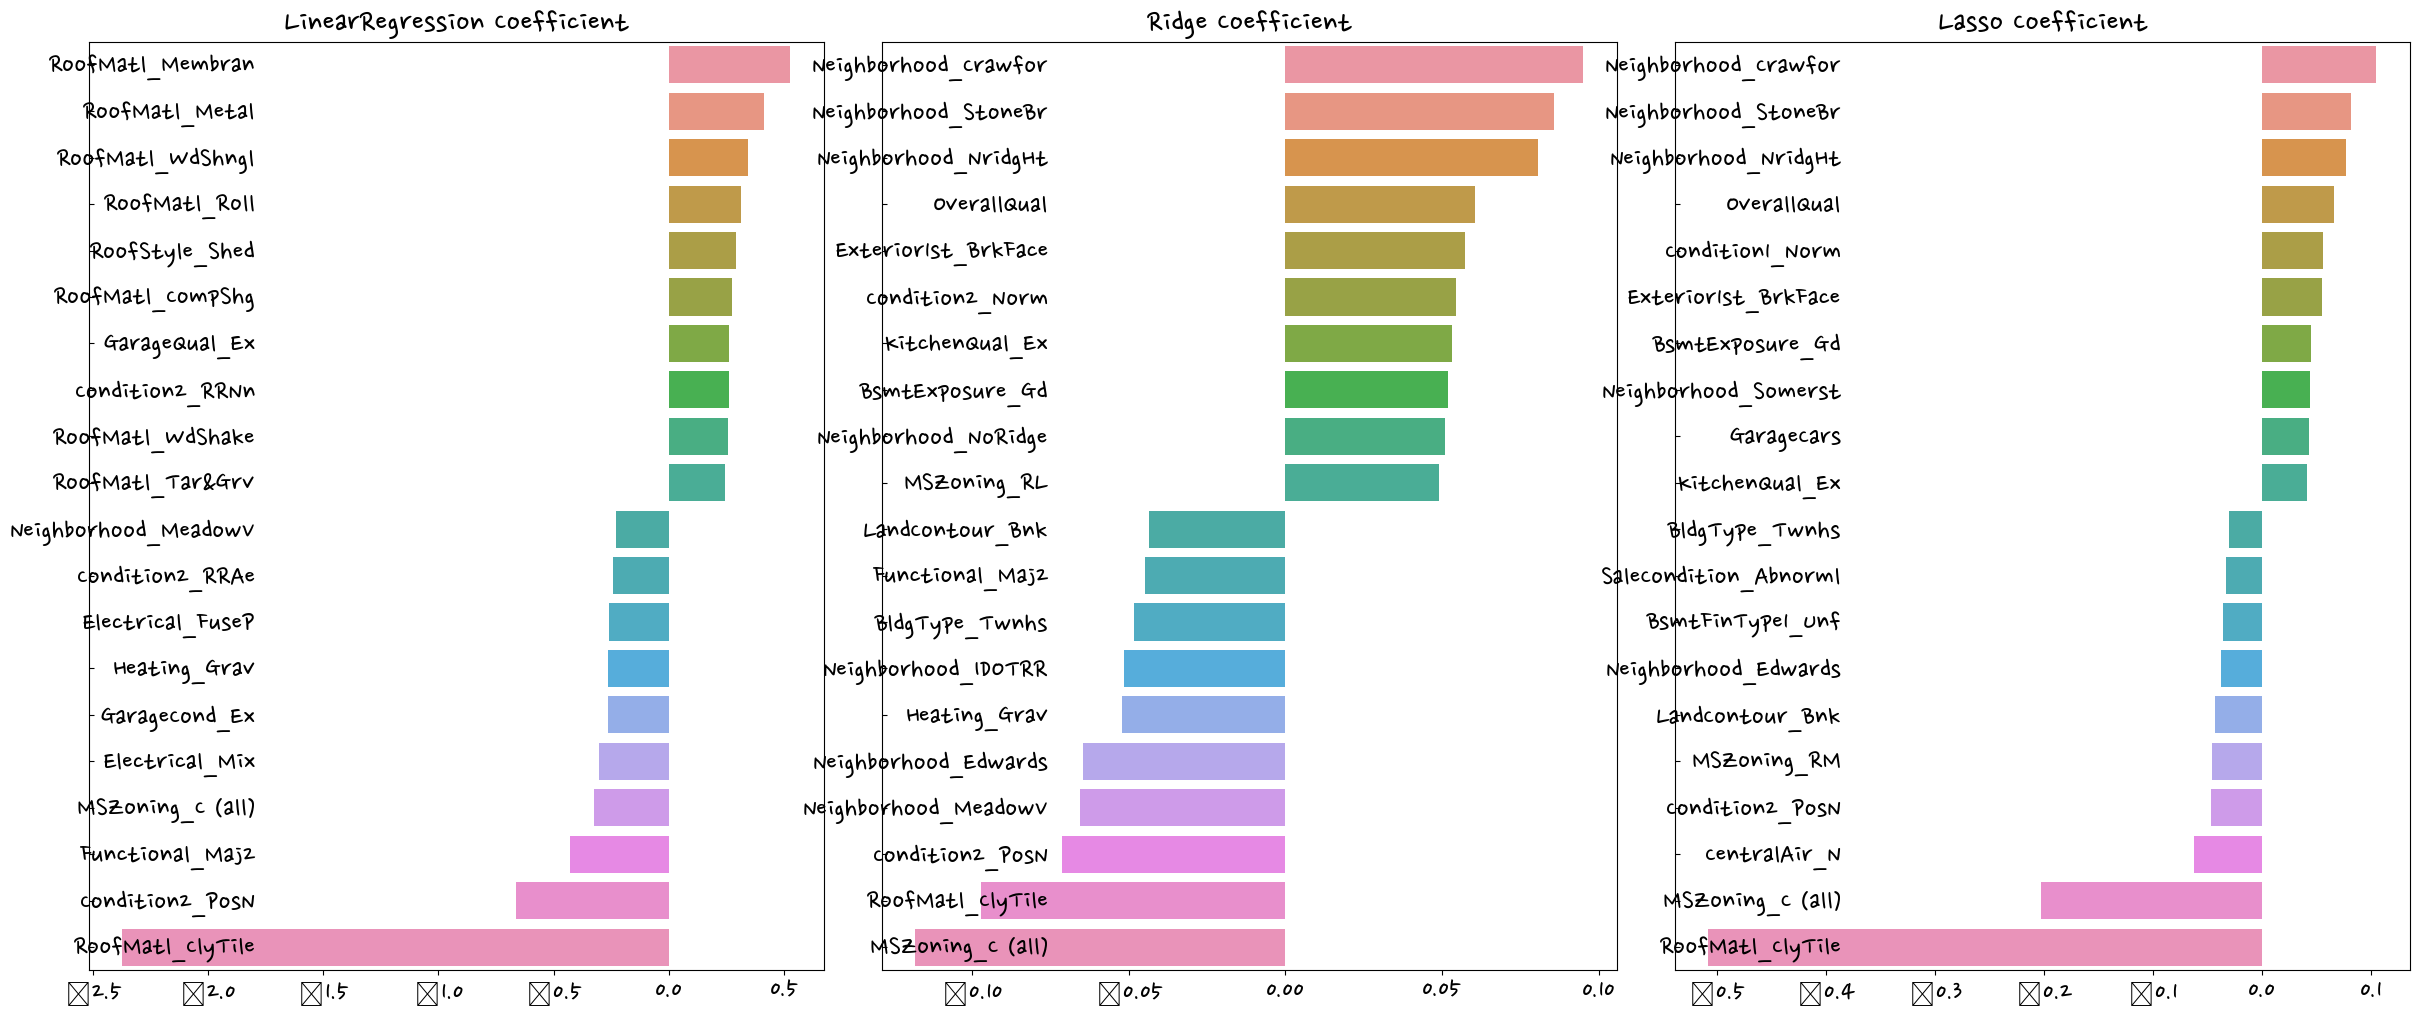

In [67]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

visualize_coefficient(models)

In [68]:
from scipy.stats import skew

In [70]:
features_index = df.dtypes[df.dtypes != 'object'].index

In [72]:
skew_features = df[features_index].apply(lambda x:skew(x))

In [74]:
skew_features_top = skew_features[skew_features>1]

In [75]:
skew_features_top.sort_values(ascending=False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [77]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

In [78]:
df_ohe = pd.get_dummies(df)
y = df_ohe['SalePrice']
X = df_ohe.drop(columns=['SalePrice'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=156)

ridge_param = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
print_best_params(ridge_reg,ridge_param)

lasso_param = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(lasso_reg,lasso_param)

Ridge 5 cv시 최적 평균 rmse 값:0.1275, 최적 alpha값:{'alpha': 10}
Lasso 5 cv시 최적 평균 rmse 값:0.1252, 최적 alpha값:{'alpha': 0.001}


LinearRegression  로그 변환된 RMSE: 0.128
Ridge  로그 변환된 RMSE: 0.122
Lasso  로그 변환된 RMSE: 0.119


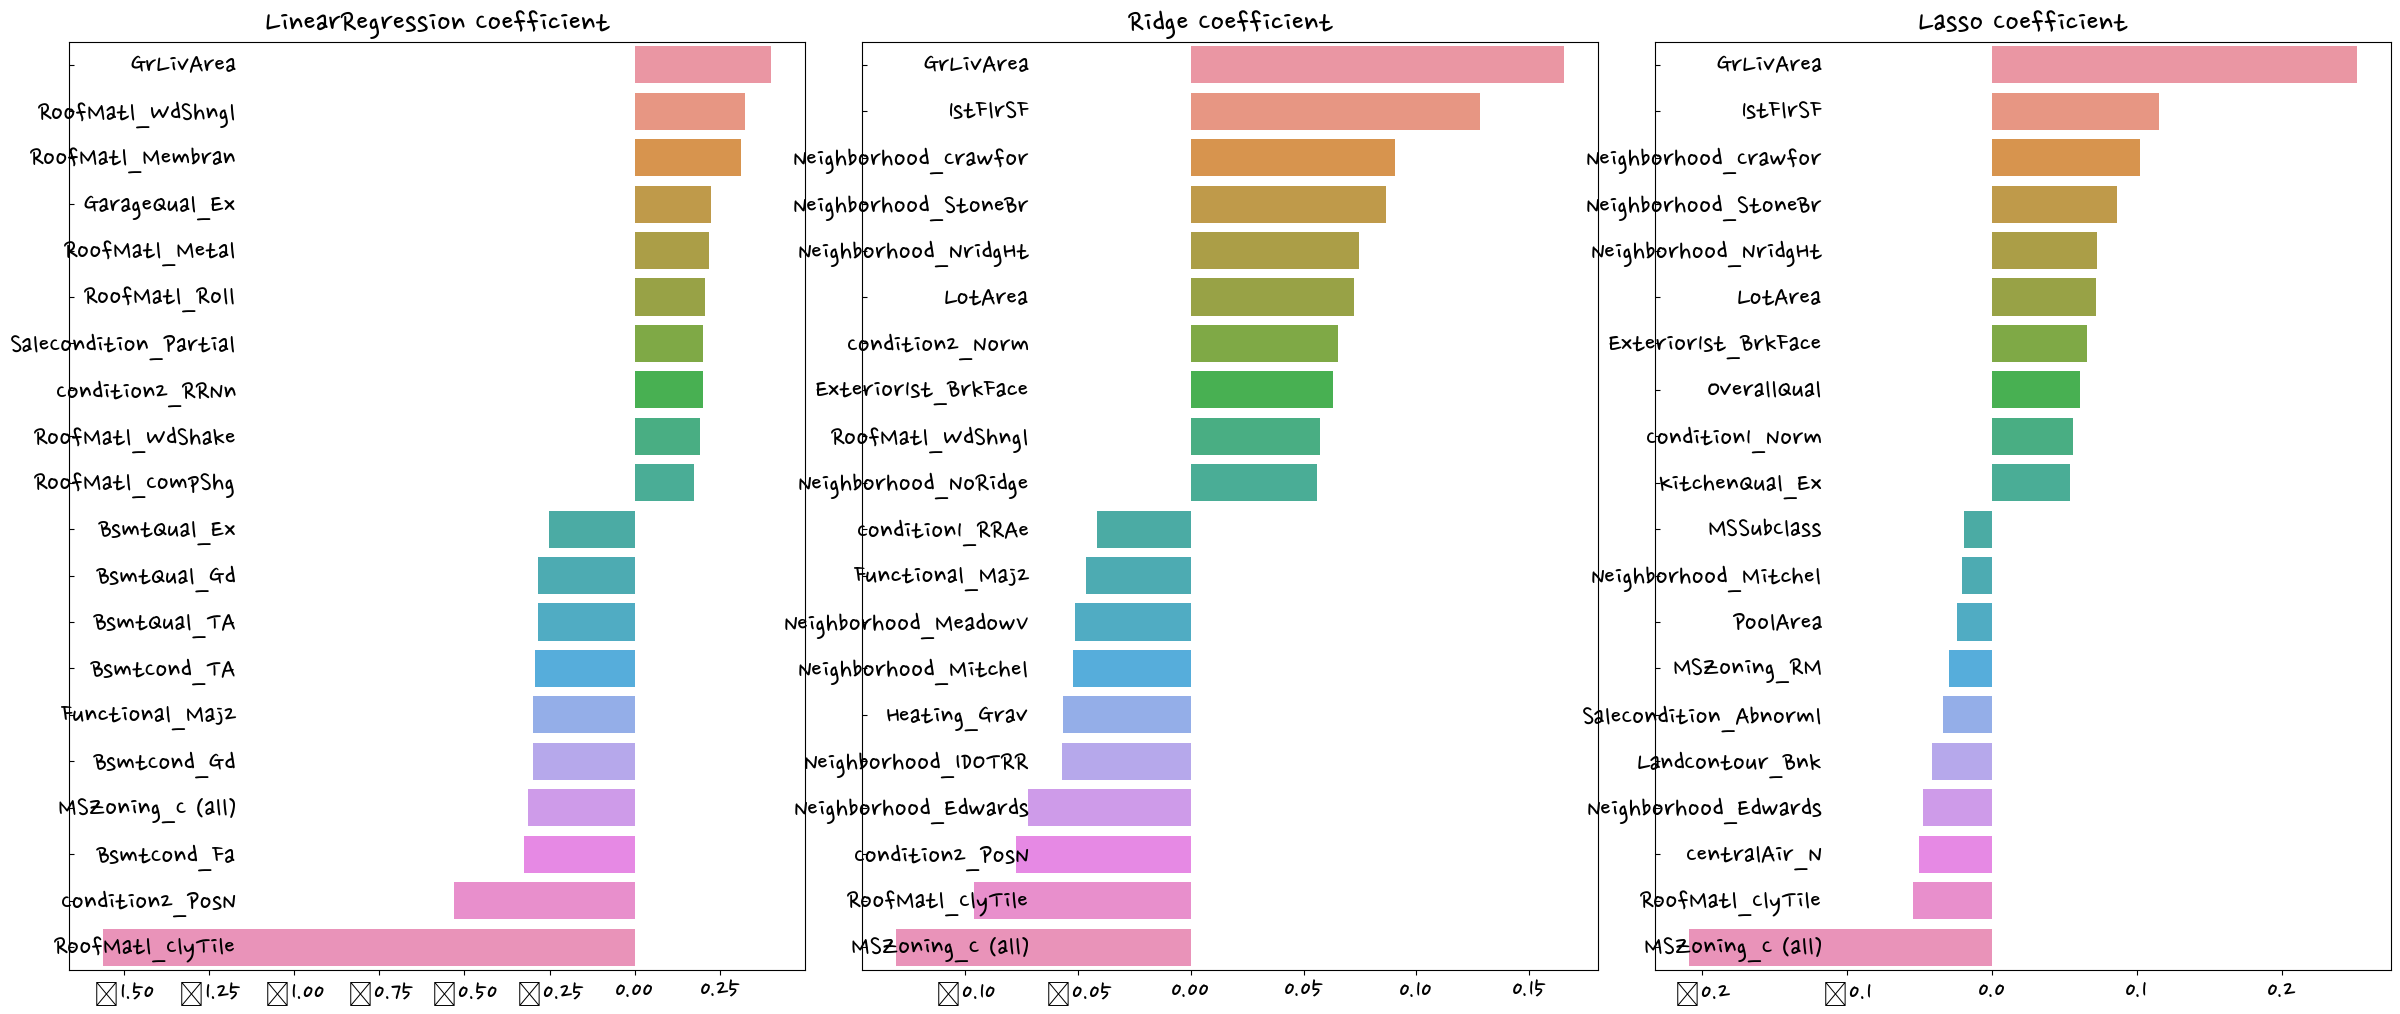

In [79]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

visualize_coefficient(models)

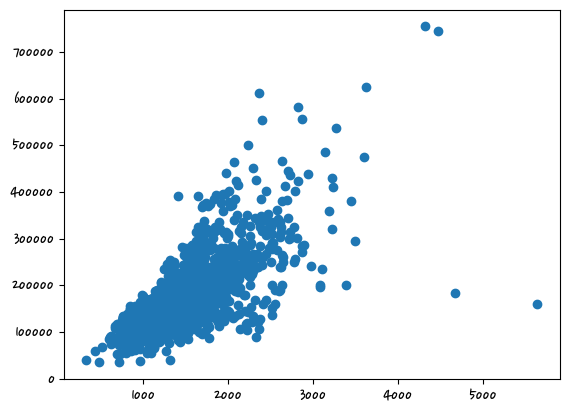

In [83]:
df_org = pd.read_csv('houseprice.csv')
plt.scatter(x=df_org['GrLivArea'],y=df_org['SalePrice'])

In [86]:
cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index

In [87]:
df_ohe.shape

(1460, 271)

In [88]:
df_ohe.drop(index=outlier_index,inplace=True)

In [89]:
df_ohe.shape

(1458, 271)

In [90]:
y = df_ohe['SalePrice']
X = df_ohe.drop(columns=['SalePrice'])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=156)

ridge_param = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
print_best_params(ridge_reg,ridge_param)

lasso_param = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(lasso_reg,lasso_param)

Ridge 5 cv시 최적 평균 rmse 값:0.1125, 최적 alpha값:{'alpha': 8}
Lasso 5 cv시 최적 평균 rmse 값:0.1122, 최적 alpha값:{'alpha': 0.001}


LinearRegression  로그 변환된 RMSE: 0.129
Ridge  로그 변환된 RMSE: 0.103
Lasso  로그 변환된 RMSE: 0.1


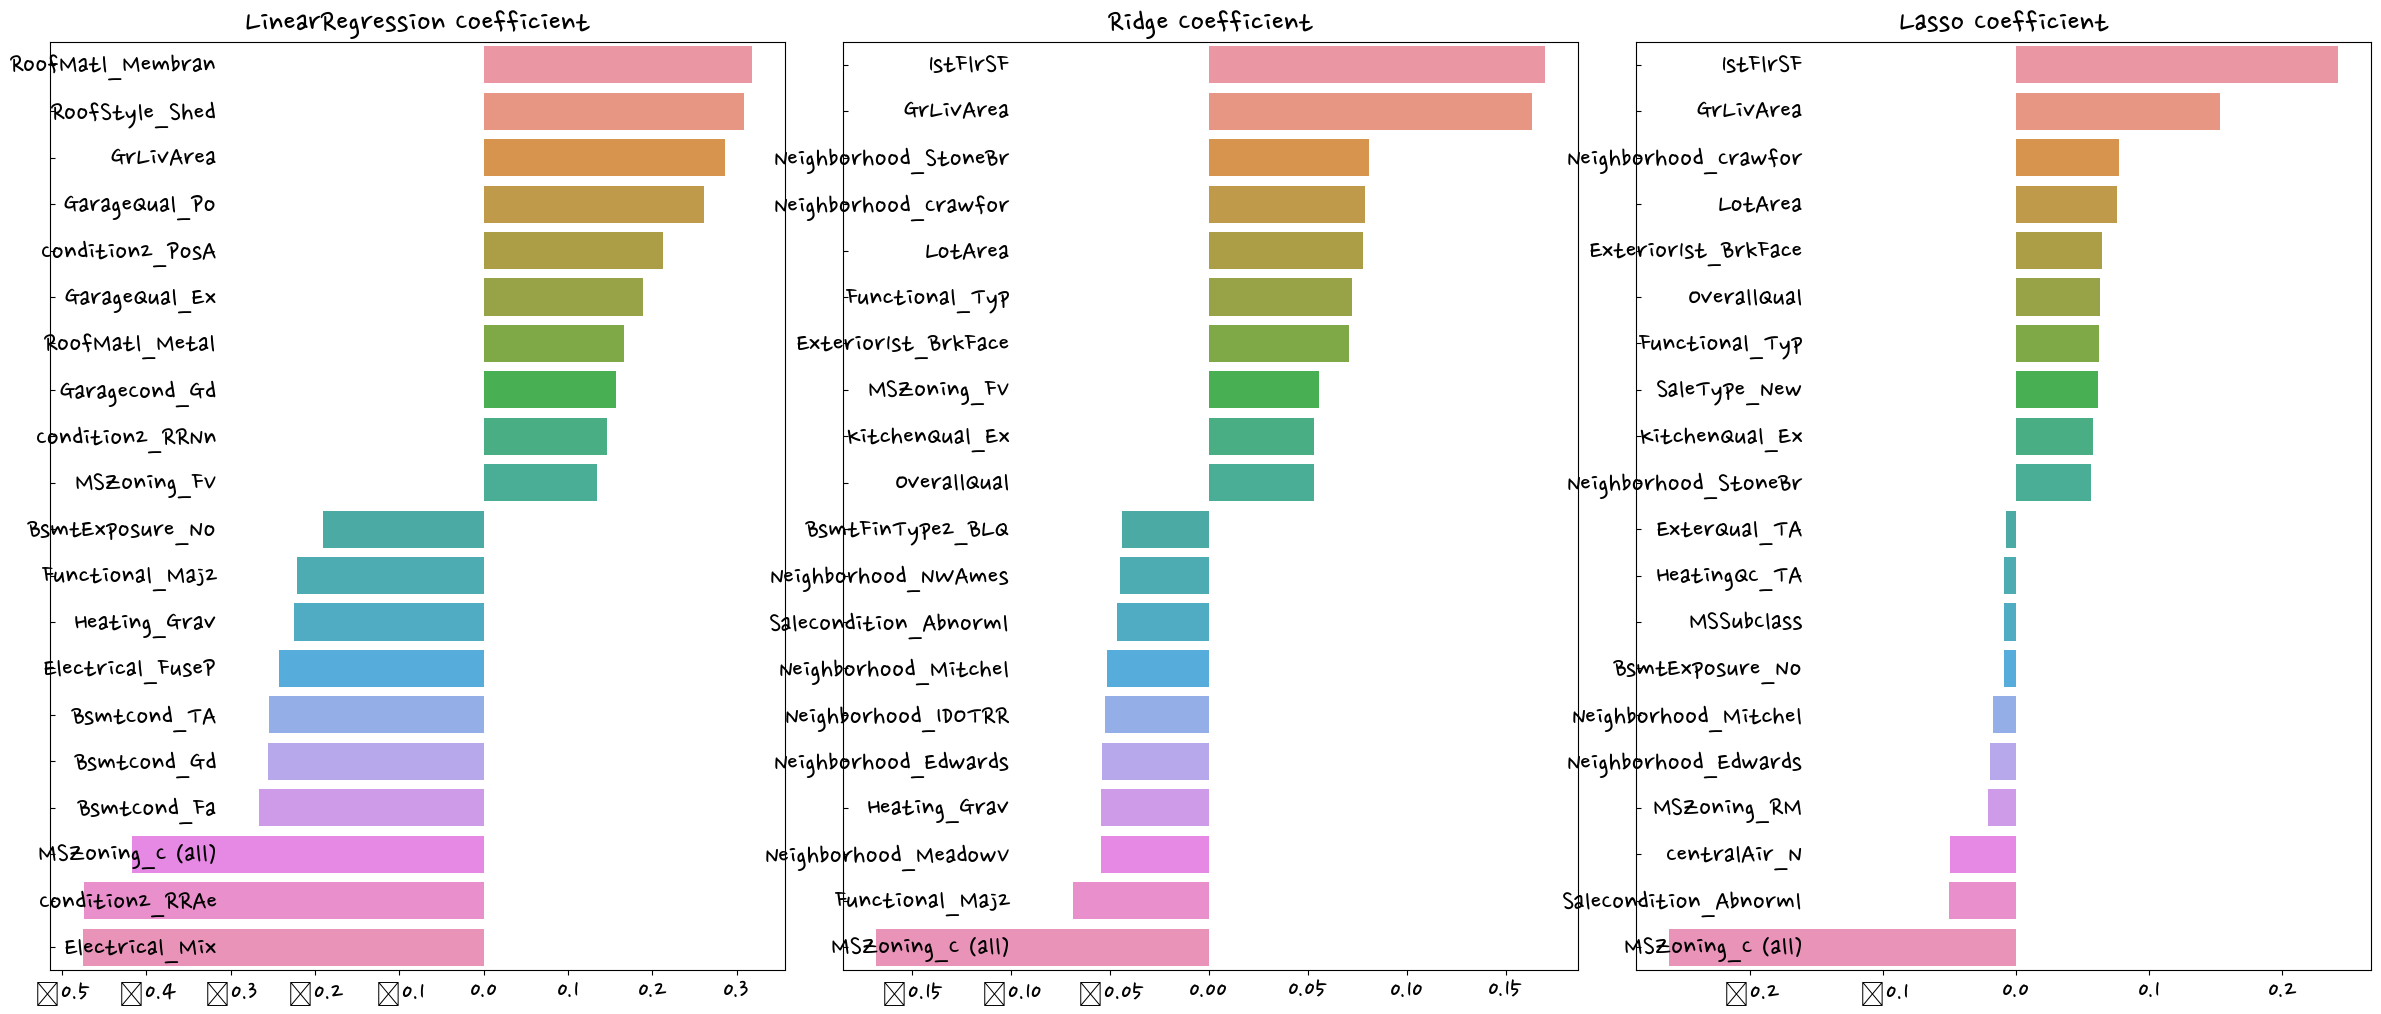

In [91]:
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train,y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train,y_train)

models=[lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

visualize_coefficient(models)
# LinearRegression  로그 변환된 RMSE: 0.128
# Ridge  로그 변환된 RMSE: 0.122
# Lasso  로그 변환된 RMSE: 0.119